In [1]:
# Import required libraries
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# DataLoader Class 
class DataLoader:
    def __init__(self, directory, label, img_size=(128, 128), mode='RGB'):
        self.directory = Path(directory)
        self.label = label
        self.img_size = img_size
        self.mode = mode
        self.images = []
        self.image_names = []
        self.labels = []

    def load_images(self):
        if not self.directory.exists():
            raise FileNotFoundError(f"Directory {self.directory} does not exist")
        
        for filepath in self.directory.glob('*'):
            if filepath.suffix.lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.gif']:
                try:
                    img = Image.open(filepath)
                    # Handle palette-based images with transparency
                    if img.mode in ['P', 'PA'] and 'transparency' in img.info:
                        img = img.convert('RGBA')  # Convert to RGBA first
                    img = img.convert(self.mode)  # Then convert to target mode (RGB)
                    img = img.resize(self.img_size)
                    self.images.append(np.array(img))
                    self.image_names.append(filepath.name)
                    self.labels.append(self.label)
                except Exception as e:
                    print(f"Error loading {filepath.name}: {e}")
        
        if not self.images:
            print(f"Warning: No valid images found in {self.directory}")
            return np.array([]), [], []
        
        return np.array(self.images), self.image_names, self.labels

In [5]:
# FeatureExtractor Class 
class FeatureExtractor:
    def __init__(self, images, image_names, labels):
        self.images = images
        self.image_names = image_names
        self.labels = labels

    def extract_features(self):
        features = []
        for i, img in enumerate(self.images):
            img_flat = img.mean(axis=2) if img.ndim == 3 else img
            features.append({
                'filename': self.image_names[i],
                'source': self.labels[i],
                'mean_intensity': np.mean(img_flat),
                'std_intensity': np.std(img_flat),
                'contrast': img_flat.max() - img_flat.min(),
                'aspect_ratio': img.shape[1] / img.shape[0]
            })
        return pd.DataFrame(features)

In [7]:
# DataAnalyzer Class 
class DataAnalyzer:
    def __init__(self, df):
        self.df = df

    def analyze(self):
        if self.df.empty:
            print("Warning: No data to analyze")
            return
        print("Summary Statistics\n", self.df.describe())
        print("\n Top 5 Images by Contrast \n", self.df.sort_values(by='contrast', ascending=False).head())

In [9]:
#  Visualizer Class 
class Visualizer:
    def __init__(self, df, images):
        self.df = df
        self.images = images  # Store the original images for display

    def plot_all(self):
        if self.df.empty:
            print("Warning: No data to visualize")
            return

        # 1. Histogram of Mean Intensity
        plt.figure(figsize=(8, 6))
        plt.hist(self.df['mean_intensity'], bins=20, color='skyblue', edgecolor='black')
        plt.title('Histogram of Mean Intensity')
        plt.xlabel('Mean Intensity')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
 
        # 2. Scatter Plot: Mean Intensity vs Contrast
        plt.figure(figsize=(8, 6))
        colors = ['blue' if src == 'Real' else 'red' for src in self.df['source']]
        plt.scatter(self.df['mean_intensity'], self.df['contrast'], c=colors, alpha=0.7)
        plt.title('Mean Intensity vs Contrast')
        plt.xlabel('Mean Intensity')
        plt.ylabel('Contrast')
        plt.grid(True)
        plt.show()
 
        # 3. Boxplot of Std Intensity
        plt.figure(figsize=(6, 6))
        plt.boxplot(self.df['std_intensity'], vert=True, patch_artist=True)
        plt.title('Boxplot of Std Deviation of Intensity')
        plt.ylabel('Standard Deviation')
        plt.grid(True)
        plt.show()

        # 5. Bar Plot: Top 10 Images by Contrast
        plt.figure(figsize=(10, 6))
        top10_df = self.df.sort_values(by='contrast', ascending=False).head(10)
        plt.bar(top10_df['filename'], top10_df['contrast'], color='purple')
        plt.title('Top 10 Images by Contrast')
        plt.xticks(rotation=90, fontsize=8)
        plt.ylabel('Contrast')
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        # 6. Display Top 10 Images
        plt.figure(figsize=(15, 10))
        for idx, (index, row) in enumerate(top10_df.iterrows()):
            filename = row['filename']
            # Find the image index in the original image list
            img_idx = self.df.index[self.df['filename'] == filename][0]
            img = self.images[img_idx]
            plt.subplot(2, 5, idx + 1)  # 2 rows, 5 columns grid
            plt.imshow(img)
            plt.title(filename)
            plt.axis('off')
        plt.suptitle('Top 10 Images by Contrast', fontsize=16)
        plt.tight_layout()
        plt.show()

=== Summary Statistics ===
        mean_intensity  std_intensity    contrast  aspect_ratio
count      971.000000     971.000000  971.000000         971.0
mean       108.138761      55.059101  237.229317           1.0
std         37.020352      13.525618   19.826823           0.0
min         13.480306      16.796591   97.666667           1.0
25%         83.678762      46.228993  228.000000           1.0
50%        105.148315      54.669204  243.666667           1.0
75%        129.471069      63.450530  252.666667           1.0
max        232.864156     120.443149  255.000000           1.0

=== Top 5 Images by Contrast ===
                                               filename source  mean_intensity  \
574                                         960x02.png     AI       80.547201   
910                                      sddefault.jpg     AI       66.007996   
412  v1_txt2img_8e704e98-ca05-4ec7-9c2c-3b6e02cad79...   Real      145.267334   
150                                  CB2953EN_

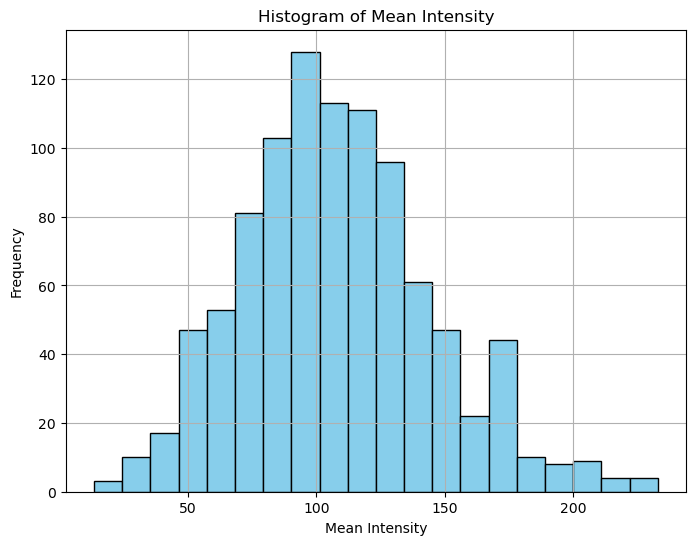

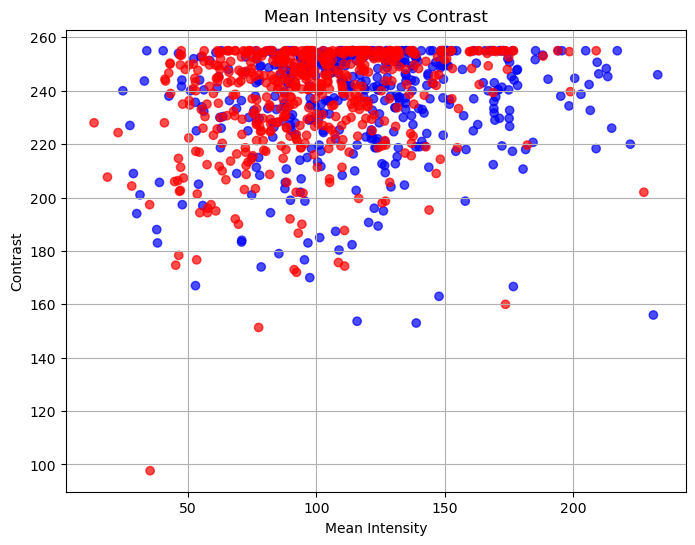

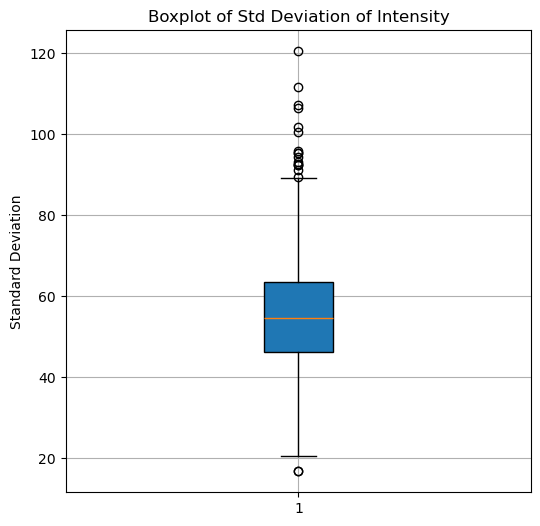

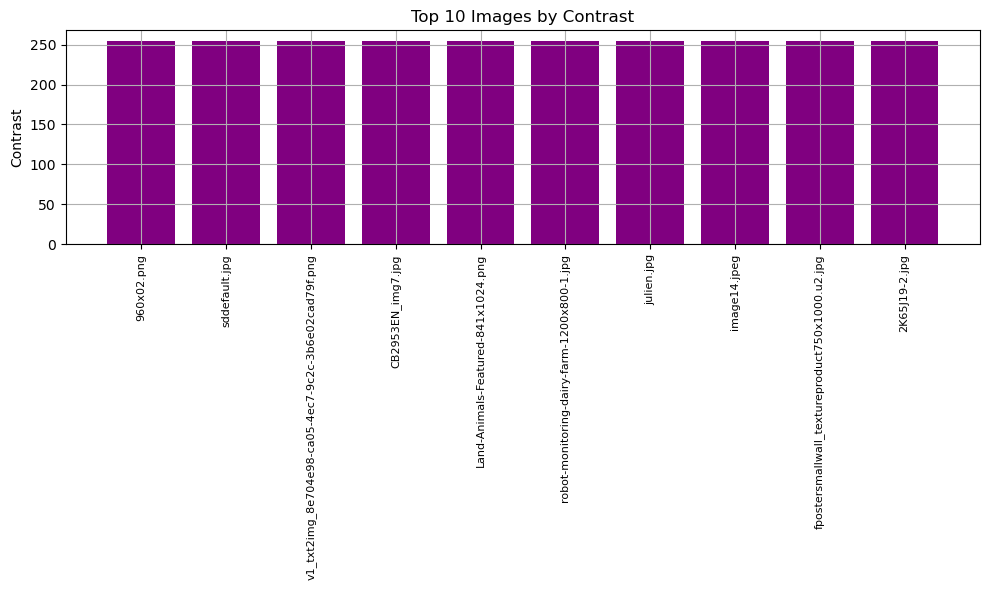

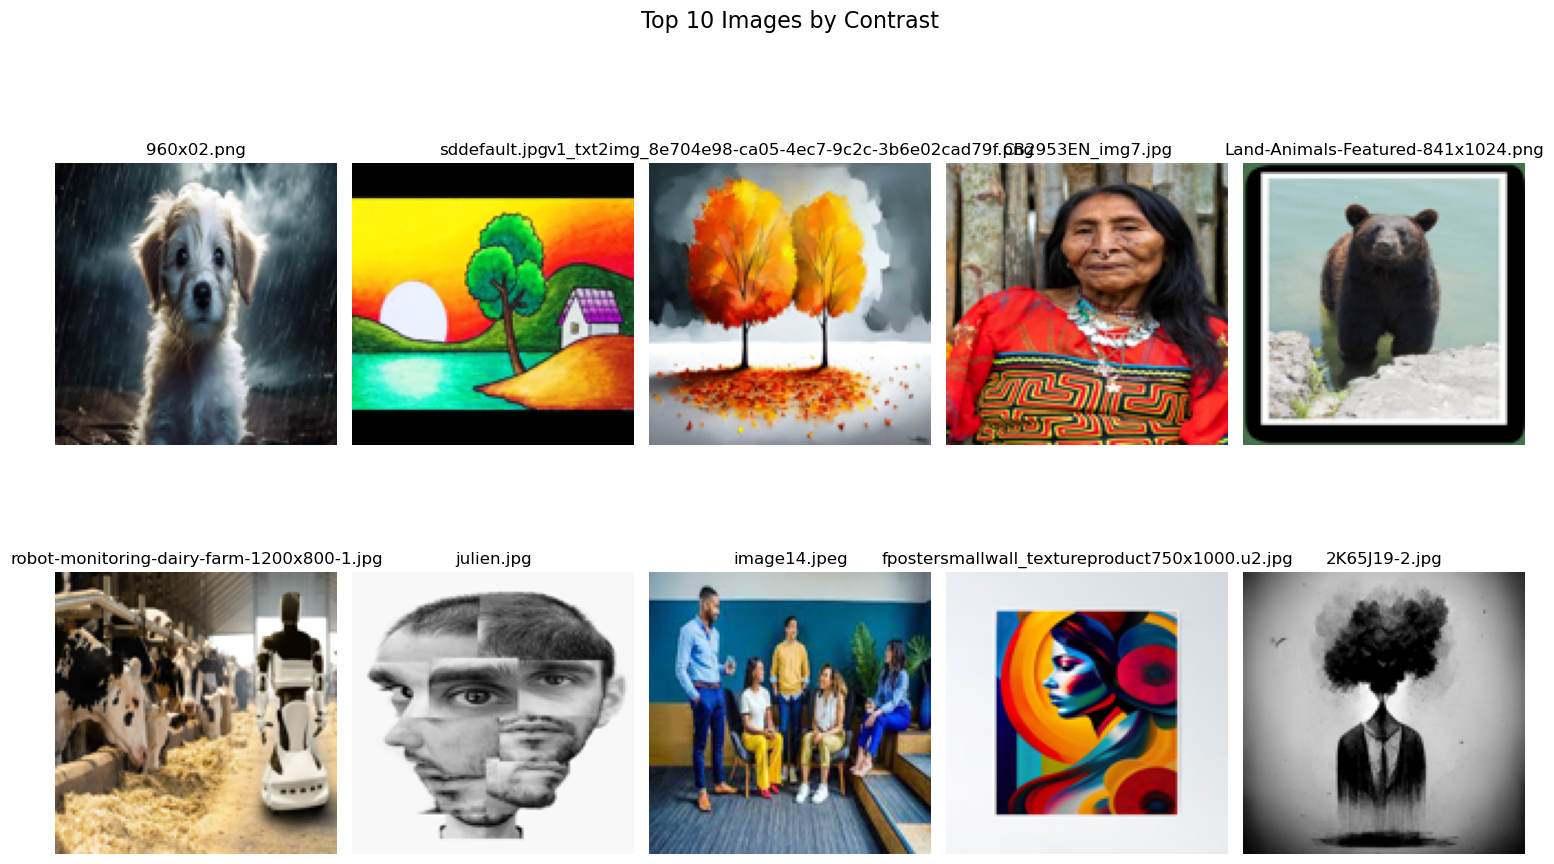

In [11]:
# === Main Execution ===
if __name__ == '__main__':
    # Set your dataset paths
    real_path = r'D:\PC\Downloads\archive (5)\RealArt\RealArt'
    ai_path = r'D:\PC\Downloads\archive (5)\AiArtData\AiArtData'

    # Load real images
    real_loader = DataLoader(real_path, label='Real')
    real_images, real_names, real_labels = real_loader.load_images()

    # Load AI images
    ai_loader = DataLoader(ai_path, label='AI')
    ai_images, ai_names, ai_labels = ai_loader.load_images()

    # Combine both
    all_images = np.concatenate([real_images, ai_images]) if real_images.size and ai_images.size else np.array([])
    all_names = real_names + ai_names
    all_labels = real_labels + ai_labels

    # Extract features
    fe = FeatureExtractor(all_images, all_names, all_labels)
    df = fe.extract_features()

    # Analyze data
    an = DataAnalyzer(df)
    an.analyze()

    # Visualize results
    viz = Visualizer(df, all_images)  # Pass all_images to Visualizer
    viz.plot_all()